In [5]:
from utils import *
from sklearn.naive_bayes  import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from nltk.corpus import stopwords
from nltk import FreqDist


import numpy as np
import nltk

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

In [31]:
# Recuperação dos textos - treinar o modelo somente com as classes POS e NEG
all_data = get_data_from_db()
# all_data = all_data[(all_data["labels"] == "PO") | (all_data["labels"] == "NG")]
ne_texts = all_data[(all_data["labels"] == "NE")]
ng_texts = all_data[(all_data["labels"] == "NG")]
po_texts = all_data[(all_data["labels"] == "PO")]
print('Textos carregados')

# lexicon = get_LIWC_lexicon()
lexicon = get_LIWC_lexicon()

print("Lexico carregado")

labels = []
for label in all_data["labels"]:
    if label == 'PO':
        labels.append(1)
    elif label == "NG":
        labels.append(-1)
    elif label == "NE":
        labels.append(0)
        
labels = np.array(labels)

Textos carregados
Lexico carregado


In [20]:
np.where(all_data["labels"] == "PO")

(array([  24,   25,   26,   27,   28,   34,   35,   43,   46,   47,   52,
          54,   55,   59,   66,   68,   70,   79,   89,   90,   91,   92,
          93,  101,  103,  104,  126,  132,  133,  139,  141,  142,  143,
         146,  148,  154,  156,  157,  160,  162,  163,  180,  188,  190,
         193,  194,  202,  203,  222,  234,  235,  236,  239,  243,  244,
         245,  246,  247,  251,  253,  260,  261,  262,  267,  272,  274,
         275,  279,  280,  281,  282,  283,  284,  293,  301,  302,  303,
         308,  310,  311,  314,  315,  321,  325,  326,  327,  328,  329,
         330,  332,  336,  338,  339,  342,  343,  346,  347,  348,  349,
         350,  351,  360,  364,  365,  366,  367,  368,  369,  392,  394,
         397,  398,  407,  409,  410,  411,  415,  418,  422,  432,  433,
         434,  435,  441,  444,  448,  449,  453,  454,  455,  456,  458,
         461,  462,  463,  464,  465,  466,  467,  480,  482,  483,  488,
         495,  503,  511,  517,  518, 

# Palavras mais e menos frequentes e numerais

In [32]:
num_remover = NumRemover()
all_data = num_remover.fit_transform(all_data)

all_texts = ''.join(all_data["texts"].tolist())
fd = FreqDist(all_texts.split())
stopwords_pt = stopwords.words("portuguese")

for word in stopwords_pt:
    if word in fd.keys():
        fd.pop(word)
    


# Stemming

In [33]:
stemmer = Stemmer()

all_texts = stemmer.fit_transform(all_data["texts"])
all_data["texts"] = all_texts

ne_texts = all_data[(all_data["labels"] == "NE")]
ng_texts = all_data[(all_data["labels"] == "NG")]
po_texts = all_data[(all_data["labels"] == "PO")]

# Preparação do LSA

<IPython.core.display.Javascript object>


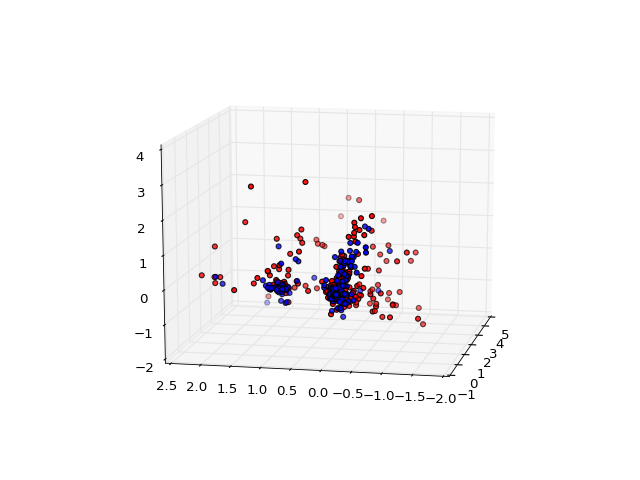

In [34]:
# cv = CountVectorizer(ngram_range = (1,2), stop_words=stopwords.words("portuguese"), vocabulary= lexicon)
# cv = TfidfVectorizer(, ngram_range = (1,2), stop_words=stopwords.words("portuguese"))

# Features
cv = FeatureUnion([
                    ("bigram", CountVectorizer(ngram_range=(2,2), stop_words= stopwords.words("portuguese"), binary= True)),
                    ("lexicon_vector", CountVectorizer(vocabulary= lexicon)),
                    ])

bag_of_words = cv.fit_transform(all_data["texts"])

svd = TruncatedSVD(n_components=10)
lsa = svd.fit_transform(bag_of_words)

pca = PCA(n_components=3)
embeddings = pca.fit_transform(lsa)

X_pos = embeddings[np.where(labels == 1)]
X_neg = embeddings[np.where(labels == -1)]
X_neut = embeddings[np.where(labels == 0)]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pos[:,0], X_pos[:,1], X_pos[:,2], c = 'b', label = "PO")
ax.scatter(X_neg[:,0], X_neg[:,1], X_neg[:,2], c = 'r', label = "NG")


# Analise de textos Neutros

In [7]:
X_neut = svd.transform(cv.transform(ne_texts["texts"]))
X_neut.shape
X_neut = pca.transform(X_neut)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_neut[:,0], X_neut[:,1], X_neut[:,2], c = 'g')
ax.set_title("Vizualização da classe neutra")

AttributeError: 'TSNE' object has no attribute 'transform'

In [9]:
bag_of_words.shape

(1042, 24676)

# Analise de Textos Negativos



<IPython.core.display.Javascript object>


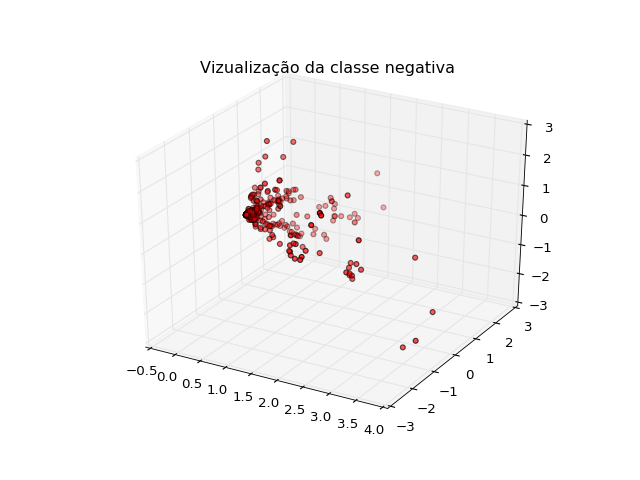

In [35]:
X_neg = svd.transform(cv.transform(ng_texts["texts"]))
# X_neg = pca.fit_transform(X_neg)
%matplotlib notebook

# from matplotlib import pyplot as plt
# plt.plot(X_neg[:,0], X_neg[:,1], 'ro')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_neg[:,0], X_neg[:,1], X_neg[:,2], c='r')
ax.set_title("Vizualização da classe negativa")

In [22]:
X_neg.shape

(391, 3)

# Analise dos textos positivos

<IPython.core.display.Javascript object>


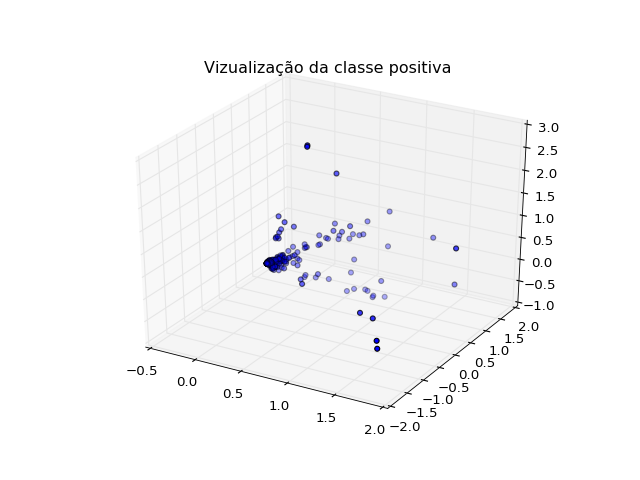

In [36]:
X_pos = svd.transform(cv.transform(po_texts["texts"]))
# X_pos = pca.fit_transform(X_pos)

%matplotlib notebook

# from matplotlib import pyplot as plt
# plt.plot(X_pos[:,0], X_pos[:,1], 'bo')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pos[:,0], X_pos[:,1], X_pos[:,2], c = 'b')
ax.set_title("Vizualização da classe positiva")

# Vizualização dos dois grupos (PO e NG)

<IPython.core.display.Javascript object>


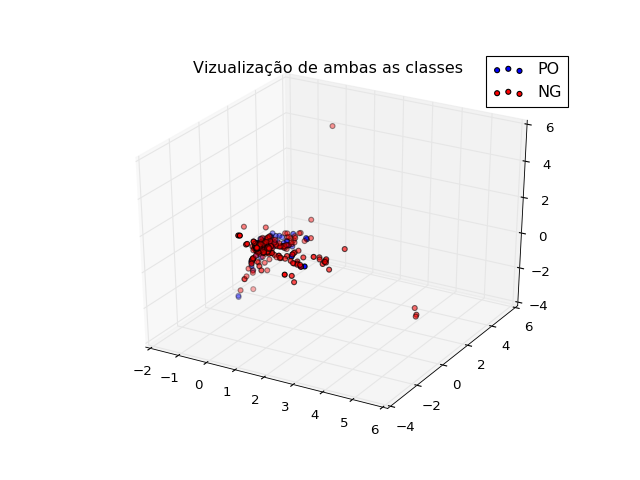

In [39]:
# from matplotlib import pyplot as plt
# plt.plot(X_neg[:,0], X_neg[:,1], 'ro', X_pos[:,0], X_pos[:,1], 'bo')

X = np.append(X_pos, X_neg, axis= 0)
pca.fit(X)

X_pos = pca.transform(X_pos)
X_neg = pca.transform(X_neg)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pos[:,0], X_pos[:,1], X_pos[:,2], c = 'b', label = "PO")
ax.scatter(X_neg[:,0], X_neg[:,1], X_neg[:,2], c = 'r', label = "NG")
ax.set_title("Vizualização de ambas as classes")
ax.legend()

# Vizualização dos dois grupos (PO e NE)

<IPython.core.display.Javascript object>


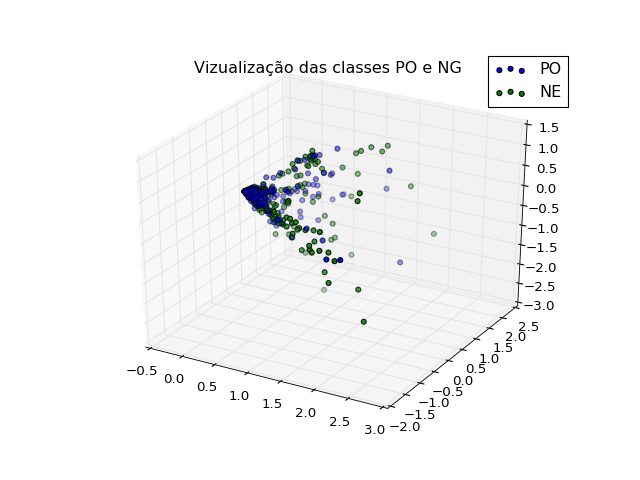

In [26]:
%matplotlib notebook
# from matplotlib import pyplot as plt
# plt.plot(X_neg[:,0], X_neg[:,1], 'ro', X_pos[:,0], X_pos[:,1], 'bo')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pos[:,0], X_pos[:,1], X_pos[:,2], c = 'b', label = "PO")
ax.scatter(X_neut[:,0], X_neut[:,1], X_neut[:,2], c = 'g', label = "NE")

ax.set_title("Vizualização das classes PO e NG")
ax.legend()

# Vizualização dos dois grupos (NG e NE)


<IPython.core.display.Javascript object>


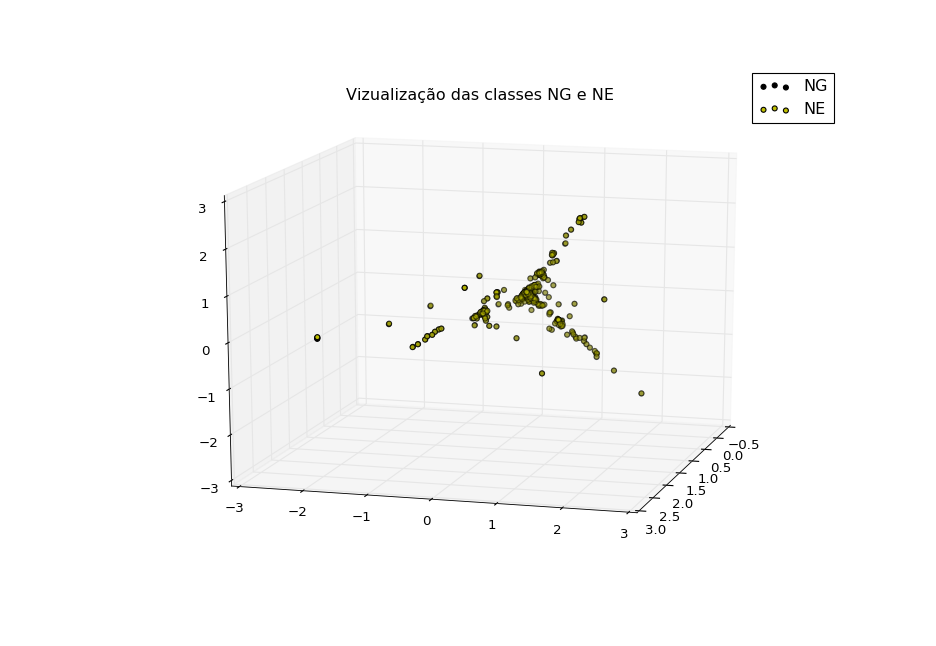

In [62]:
%matplotlib notebook
# from matplotlib import pyplot as plt
# plt.plot(X_neg[:,0], X_neg[:,1], 'ro', X_pos[:,0], X_pos[:,1], 'bo')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_neg[:,0], X_neg[:,1], X_neg[:,2], c = 'k', label = "NG")
ax.scatter(X_neut[:,0], X_neut[:,1], X_neut[:,2], c = 'y', label = "NE")

ax.set_title("Vizualização das classes NG e NE")
ax.legend()

# Visualização dos 3 grupos

<IPython.core.display.Javascript object>


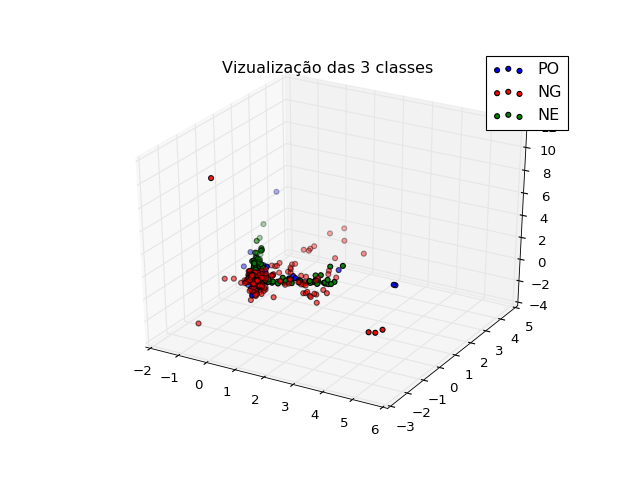

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pos[:,0], X_pos[:,1], X_pos[:,2], c = 'b', label = "PO")
ax.scatter(X_neg[:,0], X_neg[:,1], X_neg[:,2], c = 'r', label = "NG")
ax.scatter(X_neut[:,0], X_neut[:,1], X_neut[:,2], c = 'g', label = "NE")

ax.set_title("Vizualização das 3 classes")
ax.legend()

# Classificar utilizando SVM (Utilizando somente PO e NG)

In [29]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from pandas import DataFrame
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

svm = SVC(C=316)
skfold = StratifiedKFold(n_splits=10, shuffle=True)

X_pos_data = np.append(X_pos, np.ones((X_pos.shape[0],1)), axis = 1)
X_neg_data = np.append(X_neg, np.zeros((X_neg.shape[0],1)) , axis = 1)

data = np.append(X_pos_data, X_neg_data, axis=0)

accuracy_mean = 0
for index, (train, test) in enumerate(skfold.split(data[:,0:5], data[:,5])):
    x_train = data[train,0:5]
    y_train =  data[train,5]
    
    x_test = data[test,0:5]
    y_test =  data[test,5]
    
    svm.fit(x_train, y_train)
    predictions = svm.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_mean += accuracy/10
    
    print("Fold " + str(index) + " : " + str(accuracy) )
    
print("\nAccuracia media: " + str(accuracy_mean))

Fold 0 : 0.591549295775
Fold 1 : 0.628571428571
Fold 2 : 0.7
Fold 3 : 0.657142857143
Fold 4 : 0.671428571429
Fold 5 : 0.628571428571
Fold 6 : 0.614285714286
Fold 7 : 0.5
Fold 8 : 0.571428571429
Fold 9 : 0.557142857143

Accuracia media: 0.612012072435


# Classificar utilizando SVM (Utilizando todas as classes)

In [28]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from pandas import DataFrame
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

svm = SVC(C=316)
skfold = StratifiedKFold(n_splits=10, shuffle=True)

X_pos_data = np.append(X_pos, np.ones((X_pos.shape[0],1)), axis = 1)
X_neg_data = np.append(X_neg, -np.ones((X_neg.shape[0],1)), axis = 1)
X_neu_data = np.append(X_neut, np.zeros((X_neut.shape[0],1)), axis = 1)

data = np.append(X_pos_data, X_neg_data, axis=0)
data = np.append(data, X_neu_data, axis=0)

accuracy_mean = 0
for index, (train, test) in enumerate(skfold.split(data[:,0:5], data[:,5])):
    x_train = data[train,0:5]
    y_train =  data[train,5]
    
    x_test = data[test,0:5]
    y_test =  data[test,5]
    
    svm.fit(x_train, y_train)
    predictions = svm.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_mean += accuracy/10
    
    print("Fold " + str(index) + " : " + str(accuracy) )
    
print("\nAccuracia media: " + str(accuracy_mean))

Fold 0 : 0.5
Fold 1 : 0.5
Fold 2 : 0.519230769231
Fold 3 : 0.471153846154
Fold 4 : 0.509615384615
Fold 5 : 0.548076923077
Fold 6 : 0.596153846154
Fold 7 : 0.461538461538
Fold 8 : 0.509615384615
Fold 9 : 0.490384615385

Accuracia media: 0.510576923077
